#SEGAN pytorch implementation
Hyungon Ryu | Sr. Solution Architect for DL @ NVIDIA

in this jupyter notebook, I'll introduce reproduce SEGAN pytorch implementation step by step in google COLAB.
you can easily modify 

## Step1. check environment
Oct. 2018, 
 - H/W : 2 CPU cores + 350GB storage + 1 K80 GPU. 
 - S/W : 
  - Ubuntu 1704 
  - CUDA 9.0(minimal) + CUDNN 6.0 
  - python 3.6.4
  - tensforflow 0.11.0
  - keras 2.1.6
  
you can check detail information with below script : 

In [1]:
#check the environemnt 

print("Check H/W")
!echo "CPU " &&  lscpu | grep 'CPU(s):            '
!lscpu | grep GHz
! echo "memory" && free -m | cut -c-49 |  head -n 2 

! echo "storage" && df -h |  cut -c-60 | head -n 2
!df -h |  grep '/dev/sda1'

print("confure GPU")
! echo "GPU   " && nvidia-smi -L | cut -c-17
!nvidia-smi -ac 2505,875
!nvidia-smi -pm 1

print("\nCheck S/W")
!cat /etc/*-release | grep PRETTY_NAME
import sys
print("Python Version : ", sys.version)
print("Python result : 3+5=",3+5)
print("installed NVIDIA libraries")
!ls /usr/lib64-nvidia

import tensorflow as tf
import keras as K
print("tensorflow", tf.__version__)
print("keras", K.__version__)

Check H/W
CPU 
CPU(s):              2
Model name:          Intel(R) Xeon(R) CPU @ 2.30GHz
memory
              total        used        free      
Mem:          13022         395        7226      
storage
Filesystem      Size  Used Avail Use% Mounted on
overlay         359G  9.7G  331G   3% /
/dev/sda1       365G   12G  354G   4% /etc/hosts
confure GPU
GPU   
GPU 0: Tesla K80 
Applications clocks set to "(MEM 2505, SM 875)" for GPU 00000000:00:04.0


All done.
Enabled persistence mode for GPU 00000000:00:04.0.
All done.

Check S/W
PRETTY_NAME="Ubuntu 17.10"
Python Version :  3.6.3 (default, Oct  3 2017, 21:45:48) 
[GCC 7.2.0]
Python result : 3+5= 8
installed NVIDIA libraries
10_nvidia.json			libGLESv2.so
libcuda.so			libGLESv2.so.2
libcuda.so.1			libnvidia-cfg.so
libcuda.so.384.111		libnvidia-cfg.so.1
libcudnn.so			libnvidia-cfg.so.384.111
libcudnn.so.6			libnvidia-compiler.so
libcudnn.so.6.0.21		libnvidia-compiler.so.384.111
libEGL_nvidia.so		libnvidia-eglcore.so
libEGL_nvidia.so.0		l

Using TensorFlow backend.


In [2]:
%%time
#pytorch 0.4.1 519.5MB
!pip3 install torch torchvision

    100% |████████████████████████████████| 519.5MB 33kB/s 
tcmalloc: large alloc 1073750016 bytes == 0x59b36000 @  0x7f9946f1b1c4 0x46d6a4 0x5fcbcc 0x4c494d 0x54f3c4 0x553aaf 0x54e4c8 0x54f4f6 0x553aaf 0x54efc1 0x54f24d 0x553aaf 0x54efc1 0x54f24d 0x553aaf 0x54efc1 0x54f24d 0x551ee0 0x54e4c8 0x54f4f6 0x553aaf 0x54efc1 0x54f24d 0x551ee0 0x54efc1 0x54f24d 0x551ee0 0x54e4c8 0x54f4f6 0x553aaf 0x54e4c8
    100% |████████████████████████████████| 61kB 13.8MB/s 
    100% |████████████████████████████████| 2.0MB 4.9MB/s 
  Found existing installation: Pillow 4.0.0
    Uninstalling Pillow-4.0.0:
      Successfully uninstalled Pillow-4.0.0
CPU times: user 2.25 s, sys: 552 ms, total: 2.8 s
Wall time: 2min 44s


In [3]:
!rm -rf segan-pyt
!git clone https://github.com/yhgon/segan-pyt.git

Cloning into 'segan-pyt'...
remote: Enumerating objects: 24, done.
remote: Counting objects: 100% (24/24), done.
remote: Compressing objects: 100% (24/24), done.
remote: Total 179 (delta 11), reused 0 (delta 0), pack-reused 155
Receiving objects: 100% (179/179), 2.14 MiB | 2.40 MiB/s, done.
Resolving deltas: 100% (98/98), done.


In [4]:
# for audio processing, it need some audio utilities and librarys. sox also use scipy to handle audio file. 
!apt-get install sox ffmpeg 
!pip3 install librosa tqdm sox

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following additional packages will be installed:
  dbus i965-va-driver libaacs0 libapparmor1 libasound2 libasound2-data libass9
  libasyncns0 libavc1394-0 libavcodec57 libavdevice57 libavfilter6
  libavformat57 libavresample3 libavutil55 libbdplus0 libbluray2
  libboost-filesystem1.62.0 libboost-system1.62.0 libbs2b0 libcaca0 libcairo2
  libcapnp-0.5.3 libcdio-cdda1 libcdio-paranoia1 libcdio13 libchromaprint1
  libcrystalhd3 libdbus-1-3 libdc1394-22 libdrm-amdgpu1 libdrm-common
  libdrm-intel1 libdrm-nouveau2 libdrm-radeon1 libdrm2 libegl1-mesa libelf1
  libfftw3-double3 libflac8 libflite1 libfribidi0 libgbm1 libgl1-mesa-dri
  libgl1-mesa-glx libglapi-mesa libgme0 libgraphite2-3 libgsm1 libharfbuzz0b
  libiec61883-0 libjack-jackd2-0 libllvm5.0 libltdl7 libmagic-mgc libmagic1
  libmirclient9 libmircommon7 libmircore1 libmirprotobuf3 libmp3lame0
  libmpg123-0 libnuma1 libogg0 libopenal-dat

## prepare Dataset 
###  copy acquire dataset in googledrive
you could download data from below : 
copy folder to your personal google drive to save time 
[Google_Drive  Lint](https://drive.google.com/open?id=1VYfZMxmLFpl_-41LC2hQ7vM5fbHEoddP)

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


### copy and uncompress
copy compressed file and unzip the dataset


In [6]:
%%time
!ls -h   "drive/My Drive/COLAB/segan/"
!mkdir ./dataset-segan
!cp  -rf "drive/My Drive/COLAB/segan/clean_testset_wav.zip" ./dataset-segan/.
!cp  -rf "drive/My Drive/COLAB/segan/noisy_testset_wav.zip" ./dataset-segan/.
!cp  -rf "drive/My Drive/COLAB/segan/clean_trainset_wav.zip" ./dataset-segan/.
!cp  -rf "drive/My Drive/COLAB/segan/noisy_trainset_wav.zip" ./dataset-segan/.
!mkdir data
!unzip -q ./dataset-segan/clean_trainset_wav.zip -d ./data/clean_trainset_wav
!unzip -q ./dataset-segan/clean_testset_wav.zip  -d ./data
!unzip -q ./dataset-segan/noisy_trainset_wav.zip -d ./data/noisy_trainset_wav
!unzip -q ./dataset-segan/noisy_testset_wav.zip  -d ./data
!du -h data
!ls ./data/clean_trainset_wav | head -n 2
!ls ./data/clean_testset_wav  | head -n 2
!ls ./data/noisy_trainset_wav | head -n 2
!ls ./data/noisy_testset_wav  | head -n 2

clean_testset_wav.zip	generator-1.pkl		segan.tfrecords
clean_trainset_wav.zip	noisy_testset_wav.zip
discriminator-1.pkl	noisy_trainset_wav.zip
192M	data/noisy_testset_wav
1.1G	data/clean_trainset_wav
192M	data/clean_testset_wav
1.1G	data/noisy_trainset_wav
2.5G	data
p226_001.wav
p226_002.wav
p232_001.wav
p232_002.wav
p226_001.wav
p226_002.wav
p232_001.wav
p232_002.wav
CPU times: user 667 ms, sys: 163 ms, total: 830 ms
Wall time: 1min 38s


### split and make np array

In [7]:
%%time
!python segan-pyt/data_preprocess.py

Serialize and down-sample train audios: 100% 11572/11572 [01:23<00:00, 138.21it/s]
Verify serialized train audios: 100% 48640/48640 [01:13<00:00, 660.17it/s]
Serialize and down-sample test audios: 100% 824/824 [02:50<00:00,  4.08it/s]
Verify serialized test audios: 100% 2805/2805 [00:01<00:00, 2216.98it/s]
CPU times: user 4.52 s, sys: 1.08 s, total: 5.6 s
Wall time: 5min 34s


segan model assume there are two directories in working dicrection. `result` to save generated file and `epochs` directory to save parameter snapshot. but in COLAB jupyter, working directory is `content` so we need to create new folders 

In [0]:
!mkdir results
!mkdir epochs

## train the model


In [0]:
!python ./segan-pyt/main.py --batch_size 16 --num_epochs 2

loading data...
# generator parameters: 75453878
# discriminator parameters: 97473194
  0% 0/3040 [00:00<?, ?it/s]./segan-pyt/main.py:94: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
  .format(epoch + 1, clean_loss.data[0], noisy_loss.data[0], g_loss.data[0], g_cond_loss.data[0]))
Epoch 1: d_clean_loss 0.2907, d_noisy_loss 0.2077, g_loss 0.9724, g_conditional_loss 0.8310:  20% 601/3040 [19:58<1:21:33,  2.01s/it]

## test model
copy one test sample and generate file 

In [12]:
!cp data/clean_testset_wav/p232_001.wav ./p232_001-c.wav
!cp data/noisy_testset_wav/p232_001.wav ./p232_001-n.wav
!rm -rf enhanced_p232_001-n.wav
!python ./segan-pyt/test_audio.py --file_name /content/p232_001-n.wav --epoch_name generator-1.pkl

Generate enhanced audio: 100% 1/1 [00:00<00:00, 41.15it/s]


In [15]:
%%time
!cp  epochs/discriminator-1.pkl -rf "drive/My Drive/COLAB/segan/." 

CPU times: user 22.7 ms, sys: 13.1 ms, total: 35.8 ms
Wall time: 2.95 s


In [13]:
!soxi enhanced_p232_001-n.wav


Input File     : 'enhanced_p232_001-n.wav'
Channels       : 1
Sample Rate    : 16000
Precision      : 16-bit
Duration       : 00:00:01.02 = 16384 samples ~ 76.8 CDDA sectors
File Size      : 32.8k
Bit Rate       : 256k
Sample Encoding: 16-bit Signed Integer PCM



In [311]:
import os
import sys
sys.path.append('/content/segan-pyt')
 

import numpy as np
import torch
import torch.nn as nn
from scipy.io import wavfile
from torch.autograd import Variable
from tqdm import tqdm

from data_preprocess import slice_signal, window_size, sample_rate
from model import Generator
from utils import emphasis, float_to_int16 


FILE_NAME = 'p232_001-n.wav'
EPOCH_NAME = 'generator-1.pkl'

def myslice_one(file, window_size, stride, sample_rate):
    """
    Helper function for slicing the audio file
    by window size and sample rate with [1-stride] percent overlap (default 50%).
    """
    wav, sr = librosa.load(file, sr=sample_rate)
    hop = int(window_size * stride)
    slices = []
    print('windows size:', window_size)
    print('stride:', stride)
    print('hop size:', hop)
    print('sample rate:', sample_rate)
    print('wav length:', len(wav))
    for end_idx in range(window_size, len(wav), hop):
        print('end_idx: ',end_idx )  
        start_idx = end_idx - window_size
        print('start_idx: ', start_idx )
        slice_sig = wav[start_idx:end_idx]
        print('slice_sig lengh :', len(slice_sig))
        slices.append(slice_sig)
        print('slices_sig lengh :', len(slices))
    return slices

def myslice_two(file, window_size, stride , sample_rate):
    """ Return windows of the given signal by sweeping in stride fractions
    of window
    """
    wav, sr = librosa.load(file, sr=sample_rate)
    hop = int(window_size * stride)
    slices = []
    print('windows size:', window_size)
    print('stride:', stride)
    print('hop size:', hop)
    print('sample rate:', sample_rate)
    print('wav length:', len(wav))
    for start_idx, end_idx in zip(range(0, len(wav), hop),
                                range(window_size, len(wav) + hop,
                                hop)):
        print('start_idx: ', start_idx )
        print('end_idx: ',end_idx )  
        #if end_idx - start_idx < window_size:
         #   break
        slice_sig = wav[start_idx:end_idx]
        print('slice_sig lengh :', len(slice_sig))
        if slice_sig.shape[0] == window_size:
            slices.append(slice_sig)
        print('slices_sig lengh :', len(slices))
    return np.array(slices, dtype=np.int32)



generator = Generator()
generator.load_state_dict(torch.load('epochs/' + EPOCH_NAME, map_location='cpu'))
if torch.cuda.is_available():
	generator.cuda()

noisy_slices = myslice_one(FILE_NAME, window_size, 0.5, sample_rate)
print('noisy_slices size : ',len(noisy_slices) )  
enhanced_speech = []
for noisy_slice in tqdm(noisy_slices, desc='Generate enhanced audio'):
	z = nn.init.normal_(torch.Tensor(1, 1024, 8))
	noisy_slice = torch.from_numpy(emphasis(noisy_slice[np.newaxis, np.newaxis, :])).type(torch.FloatTensor)
	if torch.cuda.is_available():
		noisy_slice, z = noisy_slice.cuda(), z.cuda()
	noisy_slice, z = Variable(noisy_slice), Variable(z)
	generated_speech = generator(noisy_slice, z).data.cpu().numpy()
	generated_speech = emphasis(generated_speech, emph_coeff=0.95, pre=False)
	generated_speech = generated_speech.reshape(-1)
	enhanced_speech.append(generated_speech)

enhanced_speech = np.array(enhanced_speech).reshape(1, -1)
int16_PCM_data = float_to_int16(enhanced_speech.T)
file_name = os.path.join(os.path.dirname(FILE_NAME),
						 'enhanced_{}.wav'.format(os.path.basename(FILE_NAME).split('.')[0]))
wavfile.write(file_name, sample_rate, int16_PCM_data)

Generate enhanced audio: 100%|██████████| 2/2 [00:00<00:00, 50.82it/s]

windows size: 16384
stride: 0.5
hop size: 8192
sample rate: 16000
wav length: 27861
end_idx:  16384
start_idx:  0
slice_sig lengh : 16384
slices_sig lengh : 1
end_idx:  24576
start_idx:  8192
slice_sig lengh : 16384
slices_sig lengh : 2
noisy_slices size :  2


In [292]:
a=[]
a=np.array(range(0,27861, 8192))
print(a)

[    0  8192 16384 24576]


In [293]:
b=[]
b=np.array(range( 8192,27861+ 8192, 8192))
print(b)

[ 8192 16384 24576 32768]


In [287]:
import os
import sys
sys.path.append('/content/segan-pyt')
 

import numpy as np
import torch
import torch.nn as nn
from scipy.io import wavfile
from torch.autograd import Variable
from tqdm import tqdm

from data_preprocess import slice_signal, window_size, sample_rate
from model import Generator
from utils import emphasis, float_to_int16 


FILE_NAME = 'p232_001-n.wav'
EPOCH_NAME = 'generator-1.pkl'

def myslice(file, window_size, stride, sample_rate):
    """
    Helper function for slicing the audio file
    by window size and sample rate with [1-stride] percent overlap (default 50%).
    """
    wav, sr = librosa.load(file, sr=sample_rate)
    hop = int(window_size * stride)
    slices = []
    print('windows size:', window_size)
    print('stride:', stride)
    print('hop size:', hop)
    print('sample rate:', sample_rate)
    print('wav length:', len(wav))
    for end_idx in range(window_size, len(wav), hop):
        print('end_idx: ',end_idx )  
        start_idx = end_idx - window_size
        print('start_idx: ', start_idx )
        slice_sig = wav[start_idx:end_idx]
        print('slice_sig lengh :', len(slice_sig))
        slices.append(slice_sig)
        print('slices_sig lengh :', len(slices))
    return slices

def myslice_two(file, window_size, stride , sample_rate):
    """ Return windows of the given signal by sweeping in stride fractions
    of window
    """
    wav, sr = librosa.load(file, sr=sample_rate)
    hop = int(window_size * stride)
    slices = []
    print('windows size:', window_size)
    print('stride:', stride)
    print('hop size:', hop)
    print('sample rate:', sample_rate)
    print('wav length:', len(wav))
    for start_idx, end_idx in zip(range(0, len(wav), hop),
                                range(window_size, len(wav) + hop,
                                hop)):
        print('start_idx: ', start_idx )
        print('end_idx: ',end_idx )  
        if end_idx - start_idx < window_size:
            break
        slice_sig = wav[start_idx:end_idx]
        print('slice_sig lengh :', len(slice_sig))
        if slice_sig.shape[0] == window_size:
            slices.append(slice_sig)
        print('slices_sig lengh :', len(slices))
    return np.array(slices, dtype=np.int32)



generator = Generator()
generator.load_state_dict(torch.load('epochs/' + EPOCH_NAME, map_location='cpu'))
if torch.cuda.is_available():
	generator.cuda()

noisy_slices = myslice(FILE_NAME, window_size, 0.25, sample_rate)
enhanced_speech = []
for noisy_slice in tqdm(noisy_slices, desc='Generate enhanced audio'):
	z = nn.init.normal_(torch.Tensor(1, 1024, 8))
	noisy_slice = torch.from_numpy(emphasis(noisy_slice[np.newaxis, np.newaxis, :])).type(torch.FloatTensor)
	if torch.cuda.is_available():
		noisy_slice, z = noisy_slice.cuda(), z.cuda()
	noisy_slice, z = Variable(noisy_slice), Variable(z)
	generated_speech = generator(noisy_slice, z).data.cpu().numpy()
	generated_speech = emphasis(generated_speech, emph_coeff=0.95, pre=False)
	generated_speech = generated_speech.reshape(-1)
	enhanced_speech.append(generated_speech)

enhanced_speech = np.array(enhanced_speech).reshape(1, -1)
int16_PCM_data = float_to_int16(enhanced_speech.T)
file_name = os.path.join(os.path.dirname(FILE_NAME),
						 'enhanced_{}.wav'.format(os.path.basename(FILE_NAME).split('.')[0]))
wavfile.write(file_name, sample_rate, int16_PCM_data)

Generate enhanced audio: 100%|██████████| 3/3 [00:00<00:00, 46.87it/s]

windows size: 16384
stride: 0.25
hop size: 4096
sample rate: 16000
wav length: 27861
end_idx:  16384
start_idx:  0
slice_sig lengh : 16384
slices_sig lengh : 1
end_idx:  20480
start_idx:  4096
slice_sig lengh : 16384
slices_sig lengh : 2
end_idx:  24576
start_idx:  8192
slice_sig lengh : 16384
slices_sig lengh : 3


In [0]:
%matplotlib inline


import matplotlib.pyplot as plt
import IPython.display as ipd
import librosa
import librosa.display
import subprocess as sp
    
def display_audio(input):
  x,sr = librosa.load(input)
  print(input,x.shape,sr)
  plt.figure(figsize=(10, 3))
  librosa.display.waveplot(x, sr=sr)

  X = librosa.stft(x)
  Xdb = librosa.amplitude_to_db(abs(X))
  plt.figure(figsize=(10, 3))
  librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='hz')





Input File     : 'p232_001-c.wav'
Channels       : 1
Sample Rate    : 48000
Precision      : 16-bit
Duration       : 00:00:01.74 = 83582 samples ~ 130.597 CDDA sectors
File Size      : 167k
Bit Rate       : 768k
Sample Encoding: 16-bit Signed Integer PCM

p232_001-c.wav (38396,) 22050


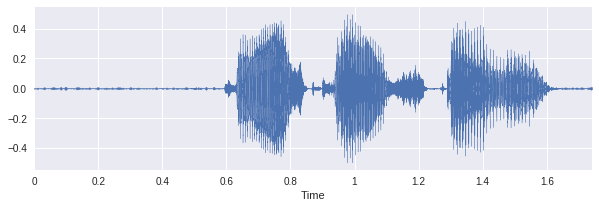

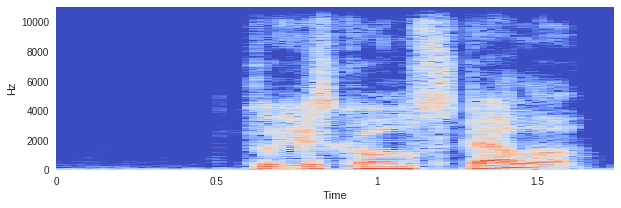

In [237]:
audio_file='p232_001-c.wav'
!soxi $audio_file
display_audio(audio_file)
ipd.Audio(audio_file)


Input File     : 'p232_001-n.wav'
Channels       : 1
Sample Rate    : 48000
Precision      : 16-bit
Duration       : 00:00:01.74 = 83582 samples ~ 130.597 CDDA sectors
File Size      : 167k
Bit Rate       : 768k
Sample Encoding: 16-bit Signed Integer PCM

p232_001-n.wav (38396,) 22050


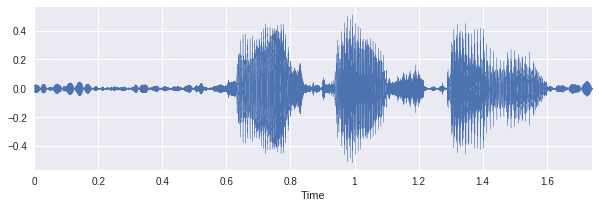

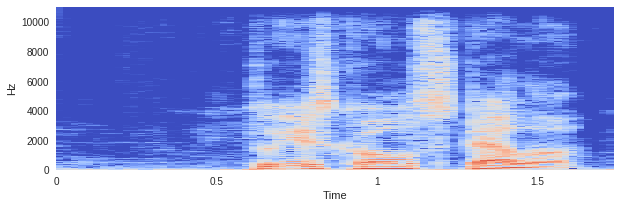

In [235]:
audio_file='p232_001-n.wav'
!soxi $audio_file
display_audio(audio_file)
ipd.Audio(audio_file,rate=16000)


Input File     : 'enhanced_p232_001-n.wav'
Channels       : 1
Sample Rate    : 16000
Precision      : 16-bit
Duration       : 00:00:01.02 = 16384 samples ~ 76.8 CDDA sectors
File Size      : 32.8k
Bit Rate       : 256k
Sample Encoding: 16-bit Signed Integer PCM

enhanced_p232_001-n.wav (22580,) 22050


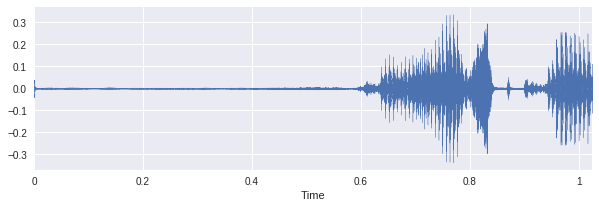

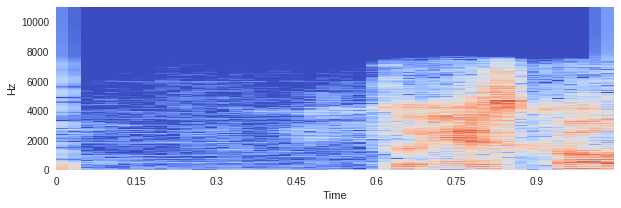

In [19]:
audio_file='enhanced_p232_001-n.wav'
!soxi $audio_file
display_audio(audio_file)
ipd.Audio(audio_file,rate=16000)

In [228]:
import numpy
sr = 22050 # sample rate
T = 4.0    # seconds
t = numpy.linspace(0, T, int(T*sr), endpoint=False) # time variable
x = 0.1*numpy.sin(numpy.sin(2*numpy.pi*20*t)*numpy.pi*40*t)                   # pure sine wave at 440 Hz
ipd.Audio(x, rate=sr) # load a NumPy array


In [0]:
import numpy as np 
def float_to_int16(y):
  """Convert floating-point numpy array of generated speech to int16 to fit in 16-bit Signed Integer PCM """
  if not issubclass(y.dtype.type, np.floating):
    raise ValueError('input samples not floating-point')
  return (y * np.iinfo(np.int16).max).astype(np.int16)

In [0]:
import scipy
scipy.io.wavfile.write('nptest.wav',  22050, float_to_int16(x) )

In [231]:
!soxi nptest.wav


Input File     : 'nptest.wav'
Channels       : 1
Sample Rate    : 22050
Precision      : 16-bit
Duration       : 00:00:04.00 = 88200 samples ~ 300 CDDA sectors
File Size      : 176k
Bit Rate       : 353k
Sample Encoding: 16-bit Signed Integer PCM



./nptest.wav (88200,) 22050


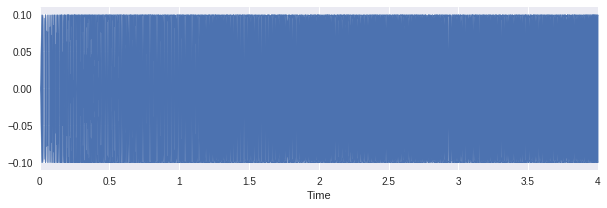

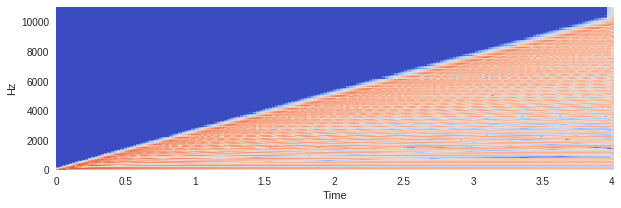

In [233]:
audio_file='./nptest.wav'
display_audio(audio_file)
ipd.Audio(audio_file,rate=22050)

In [87]:
!soxi p232_001-n.wav


Input File     : 'p232_001-n.wav'
Channels       : 1
Sample Rate    : 48000
Precision      : 16-bit
Duration       : 00:00:01.74 = 83582 samples ~ 130.597 CDDA sectors
File Size      : 167k
Bit Rate       : 768k
Sample Encoding: 16-bit Signed Integer PCM



In [165]:
!soxi enhanced_p232_001-n.wav


Input File     : 'enhanced_p232_001-n.wav'
Channels       : 1
Sample Rate    : 16000
Precision      : 53-bit
Duration       : 00:00:01.02 = 16384 samples ~ 76.8 CDDA sectors
File Size      : 131k
Bit Rate       : 1.02M
Sample Encoding: 64-bit Floating Point PCM

